In [1]:
import os, pickle
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.svm import SVC, LinearSVC
# from aix360.algorithms.protodash import ProtodashExplainer
# from lime.lime_tabular import LimeTabularExplainer
# from lime.submodular_pick import SubmodularPick
import matplotlib.pyplot as plt
from pdash import pdash_e, proto_g
# from protoclass.protoclass import ProtoclassExplainer, protoclass

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")
import utils

In [2]:
METRIC = "auc"
WEIGHTS = "uniform"
LINEAR = True

def get_knn_score(k, data, index, metric=METRIC, weights=WEIGHTS):
    X_train, y_train, X_valid, y_valid = data
    knc = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knc.fit(X_train[index], y_train[index])
    if metric == 'auc':
        probs = knc.predict_proba(X_valid)
        probs = probs[:, 1] if probs.shape[1] > 1 else probs
        score = roc_auc_score(y_valid, probs)
    else:
        score = knc.score(X_valid, y_valid)
    return score

def get_svm_score(k, data, index, metric=METRIC, linear=LINEAR):
    X_train, y_train, X_valid, y_valid = data
    svc = LinearSVC(random_state=42) if linear else SVC(probability=True, random_state=42)
    svc.fit(X_train[index], y_train[index])
    if metric == 'auc':
        probs = svc.decision_function(X_valid) # if linear else svc.predict_proba(X_valid)
        probs = probs[:, 1] if len(probs.shape) > 1 and probs.shape[1] > 1 else probs
        score = roc_auc_score(y_valid, probs)
    else:
        score = svc.score(X_valid, y_valid)
    return score

def get_ci(samples, confidence=0.95):
    return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)

def get_nn(index, samples, m=1):
    dist = euclidean_distances(samples)
    neighbors = []
    for i in index:
        neighbors.append(np.argsort(dist[i])[1:m+1])
    return np.array(neighbors)



In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def vis_data(x_train, y_train, x_valid, y_valid, title, save=False):
    classes = np.unique(y_train)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i, data in enumerate([(x_train, y_train),(x_valid, y_valid)]):
        x, y = data
        for c in classes:
            c_idx = np.where(y==c)[0]
            ax[i].scatter(x[c_idx][:,0], x[c_idx][:,1])

        ax[i].legend(['non-cancer','cancer'])
        ax[i].set_title("{}".format("train" if i == 0 else "valid"))
    
    utils.normalize_xylim(ax)
    fig.suptitle(title)
    if save:
        plt.savefig(f"{title}.png", dpi=300)

def vis_proto(x_train, y_train,train_proto_idx, title, save=False, order=False, eps=0, x_valid=None, y_valid=None,valid_proto_idx=None):
    classes = np.unique(y_train)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # for i, data in enumerate([(x_train, y_train),(x_valid, y_valid)]):
    for i, data in enumerate([(x_train, y_train)]):
        x, y = data
        for c in classes:
            c_idx = np.where(y==c)[0]
            ax[i].scatter(x[c_idx][:,0], x[c_idx][:,1])
        ax[i].legend(['non-cancer','cancer'])
        ax[i].set_title(title)
        # ax[i].set_title("{}.{}.{}".format(model, name, "train" if i == 0 else "valid"))

    for j, c in enumerate(classes):
        train_proto = x_train[[int(i) for i in train_proto_idx if y_train[i] == c]]
        ax[0].scatter(train_proto[:,0], train_proto[:,1], s=300, c=f"C{str(j)}", marker='^', linewidths=1, edgecolors='k') 
        # valid_proto = x_valid[[int(i) for i in valid_proto_idx if y_valid[i] == c]]
        # ax[1].scatter(valid_proto[:,0], valid_proto[:,1], s=300, c=f"C{str(j)}",marker='^', linewidths=1, edgecolors='k') 

    for o, i in enumerate(train_proto_idx):
        proto = x_train[i]
        c = plt.Circle(proto, radius=eps, fill=False,lw=0.75)
        
        if order:
            ax[0].text(proto[0],proto[1],str(o), size="xx-large", weight="bold", c="0")
        ax[0].add_patch(c)

    if save:
        plt.savefig(f"{title}.png", dpi=300)

def vis_triplets(x_train, y_train, triplet_dict, title, save=False):
    classes = np.unique(y_train)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i, data in enumerate([(x_train, y_train)]):
        x, y = data
        for c in classes:
            c_idx = np.where(y==c)[0]
            ax[i].scatter(x[c_idx][:,0], x[c_idx][:,1])
        
        ax[i].legend(['non-cancer','cancer'])
        ax[i].set_title("{}".format("train" if i == 0 else "valid"))
    
    for i, triplet in enumerate(triplet_dict):
        anchor, pos, neg = triplet
        anchor = x_train[anchor]
        pos = x_train[pos]
        neg = x_train[neg]
        ax[0].scatter(anchor[0], anchor[1], s=300, c='0.5', marker='^', linewidths=1, edgecolors='k') 
        ax[0].scatter(pos[0], pos[1], s=300, c='0', marker='^', linewidths=1, edgecolors='k') 
        ax[0].scatter(neg[0], neg[1], s=300, c='1', marker='^', linewidths=1, edgecolors='k') 
        ax[0].text(anchor[0], anchor[1], str(i), c='0', size="xx-large", weight="bold") 
        ax[0].text(pos[0], pos[1], str(i), c='0', size="xx-large", weight="bold") 
        ax[0].text(neg[0], neg[1], str(i), c='0', size="xx-large", weight="bold") 

    # utils.normalize_xylim(ax)
    fig.suptitle(title)
    if save:
        plt.savefig(f"{title}.png", dpi=300)

def vis_proto_2(x_train, y_train, proto_idx1, proto_idx2, title, save=False, order=False, eps=0):
    classes = np.unique(y_train)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i, data in enumerate([(x_train, y_train)]):
        x, y = data
        for c in classes:
            c_idx = np.where(y==c)[0]
            ax[i].scatter(x[c_idx][:,0], x[c_idx][:,1])
        ax[i].legend(['non-cancer','cancer'])
        ax[i].set_title(title)

        protos1 = x_train[proto_idx1]
        protos2 = x_train[proto_idx2]
        ax[i].scatter(protos1[:,0], protos1[:,1], s=300, c = 'g', marker='^', linewidths=1, edgecolors='k') 
        ax[i].scatter(protos2[:,0], protos2[:,1], s=300, c = 'r', marker='^', linewidths=1, edgecolors='k') 
    if save:
        plt.savefig(f"{title}.png", dpi=300)
    
def vis_knn(k_range, m_range, scores, legend, title, save=False):
    lw = 3
    fig, ax = plt.subplots(1, len(k_range), figsize=(24,6), sharey=True)
    for k in range(len(k_range)):
        for score in scores:
            ax[k].plot(m_range, score[k], lw=lw)

        ax[k].legend(legend, loc='lower right')
        ax[k].set_title('K={}'.format(k_range[k]))
    fig.suptitle(title)

    if save:
        plt.savefig(f"{title}.png", dpi=300)

## generate triplets from LPIPS distance matrices
triplets.shape := [k, 3]

triplets[i] = [anchor, positive, negative]

In [3]:
d_train = pickle.load(open("lpips.prostatex.train.pkl", "rb"))
d_valid = pickle.load(open("lpips.prostatex.valid.pkl", "rb"))
d_train.shape

(256, 256)

In [40]:
np.array(triplets).shape

(16581120, 3)

In [42]:
pickle.dump(np.array(triplets), open("lpips_triplets_all.prostatex.train.pkl","wb"))

In [5]:
import tste
triplets_ids = pickle.load(open("lpips_triplets_all.prostatex.train.pkl","rb"))
no_dims = 2
max_iter = 1000
embedding = tste.tste(triplets_ids, no_dims=no_dims, verbose=True, max_iter=max_iter)
pickle.dump(embedding, open("lpips_tste_all.prostatex.train.pkl","wb"))

Iteration  10  error is  8418421.117957268 , number of constraints:  0.1628791058746333
Iteration  20  error is  7115226.642136982 , number of constraints:  0.15249464451134784
Iteration  30  error is  6952963.7257821495 , number of constraints:  0.15203816147522
Iteration  40  error is  6876714.092549326 , number of constraints:  0.15195167757063455
Iteration  50  error is  6827523.555653749 , number of constraints:  0.1518264749305234
Iteration  60  error is  6792455.975145008 , number of constraints:  0.15177515149760692
Iteration  70  error is  6766411.938466717 , number of constraints:  0.15176254680021614
Iteration  80  error is  6746014.137244044 , number of constraints:  0.15172841159101436
Iteration  90  error is  6729429.333280637 , number of constraints:  0.151724069302918
Iteration  100  error is  6715571.777076451 , number of constraints:  0.15170959500926354
Iteration  110  error is  6703748.979109414 , number of constraints:  0.15169801557433998
Iteration  120  error is 

In [37]:
import tste
triplets_ids = pickle.load(open("lpips_triplets.prostatex.train.pkl","rb"))
no_dims = 2
max_iter = 1000
embedding = tste.tste(triplets_ids, no_dims=no_dims, verbose=True, max_iter=max_iter)
pickle.dump(embedding, open("lpips_tste.prostatex.train.pkl","wb"))

Iteration  10  error is  3830917.2316070464 , number of constraints:  0.4645043278138027
Iteration  20  error is  3781461.742512683 , number of constraints:  0.44319310155164426
Iteration  30  error is  3771972.2029491947 , number of constraints:  0.4393080202061139
Iteration  40  error is  3769475.089725978 , number of constraints:  0.4384068144974525
Iteration  50  error is  3768854.4924979364 , number of constraints:  0.4382331229735989
Iteration  60  error is  3768058.1236028364 , number of constraints:  0.4377516717809171
Iteration  70  error is  3767142.6848663297 , number of constraints:  0.4369479866257527
Iteration  80  error is  3766303.417913801 , number of constraints:  0.43636449166280683
Iteration  90  error is  3765695.7696943437 , number of constraints:  0.43608151922186195
Iteration  100  error is  3765229.4639565237 , number of constraints:  0.43587290846456694
Iteration  110  error is  3764867.6440357124 , number of constraints:  0.4357828059865679
Iteration  120  er

(256, 2)

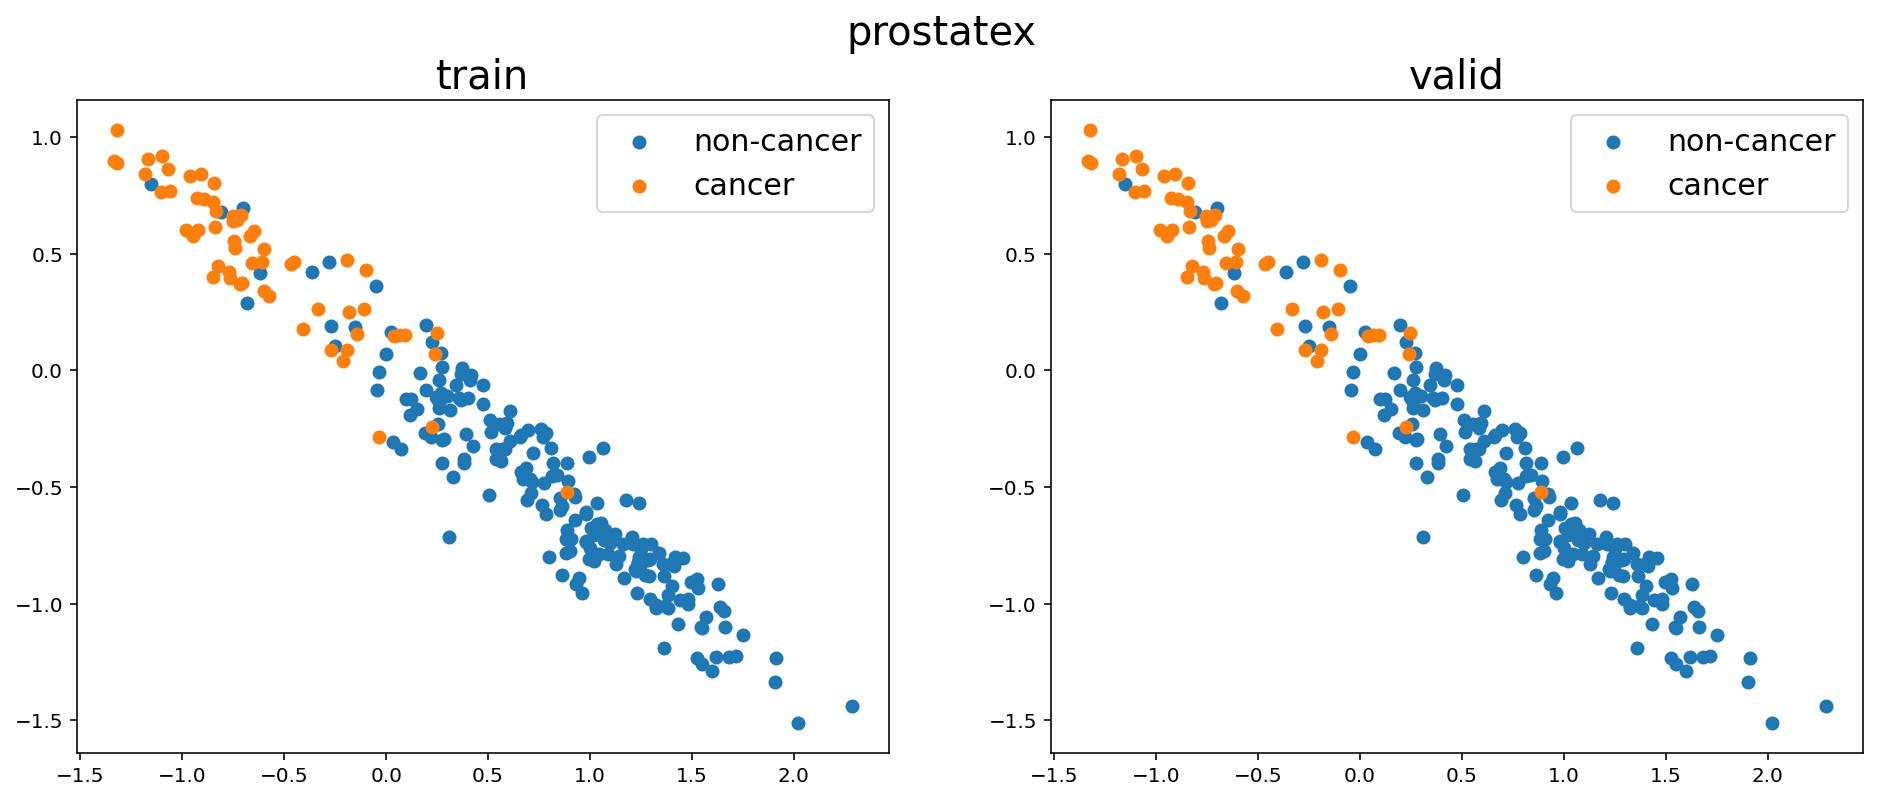

In [4]:
model, name = 'dwac', 'emb10.merged2'
title = "prostatex"

train_path = '{}_train_{}.pkl'.format(model, name)
f_train_dwac, y_train_dwac, x_train_dwac = pickle.load(open(train_path, "rb"))
vis_data(x_train_dwac, y_train_dwac, x_train_dwac, y_train_dwac, title, save=False)
x_train_dwac.shape

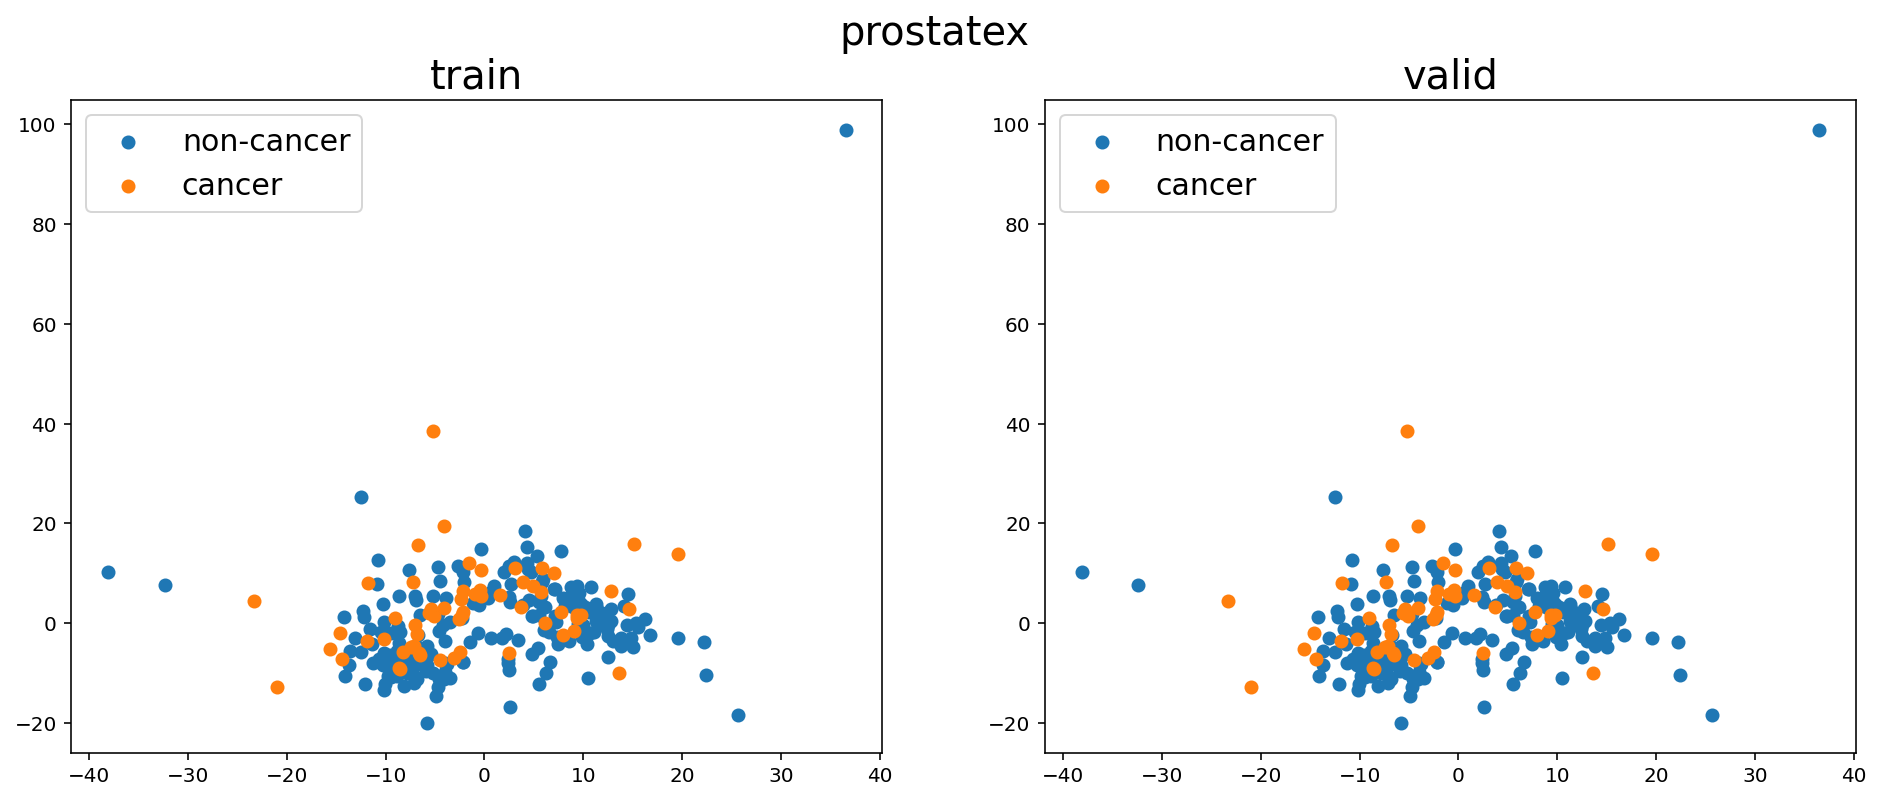

In [6]:
vis_data(embedding, y_train_dwac, embedding, y_train_dwac, title, save=False)

In [201]:
# filename_train = sorted(os.listdir("data/bm/train/0") + os.listdir("data/bm/train/1"), key=lambda x : int(os.path.splitext(x)[0]))
# K_train = d_train[[filename_train.index(i) for i in f_train]]
# index = proto_g(X_train, np.arange(len(X_train)), 10, K=K_train)
l_scores_knn, l_scores_svm = [], []
for m in m_range:
    mp, mn = (m+1)//2, m//2
    pos_index = proto_g(X_pos, np.arange(X_pos.shape[0]), m=mp, K=d_train)
    neg_index = proto_g(X_neg, np.arange(X_neg.shape[0]), m=mn, K=d_train)
    pos_index = pos_id[pos_index]
    neg_index = neg_id[neg_index]
    index = np.hstack((pos_index, neg_index))
    # proto_id = [filename_train.index(i) for i in f_train[index]]
    for k in k_range:
        # y_pred = (y_train[index][d_valid[proto_id].argsort(axis=0)[:k]].sum(0) > k/2).astype(int)
        y_pred = (y_train[index][d_valid[index].argsort(axis=0)[:k]].sum(0) > k/2).astype(int)
        k_score = roc_auc_score(y_valid, y_pred) # accuracy_score(y_valid, y_pred
        # k_score = get_knn_score(k, data, index)
        l_scores_knn.append(k_score)
    s = get_svm_score(k, data, index)
    l_scores_svm.append(s)
l_scores_knn = np.array(l_scores_knn).reshape(len(m_range), len(k_range)).T
l_scores_svm = np.array(l_scores_svm)

In [184]:
p_idss = {}
X_train, y_train, X_valid, y_valid = data
for m in m_range:
    if m not in p_idss:
        try:
            protodash = ProtodashExplainer()
            _, index, _ = protodash.explain(X_train, X_train, m=m, kernelType="Gaussian")
        except AttributeError:
            index = [0] * m
            print("error for m={}".format(m))
        p_idss[m] = index
# pickle.dump(p_idss, open("p_index.dwac.emb10.merged.pkl", "wb"))
# p_idss = pickle.load(open("p_index.dwac.emb10.merged.pkl", "rb"))
p_scores_knn, p_scores_svm = [], []
for k in k_range:
    for m in m_range:
        p_scores_knn.append(get_knn_score(k, data, p_idss[m]))
        try:
            s = get_svm_score(k, data, p_idss[m])
        except:
            s = 0
        p_scores_svm.append(s)
p_scores_knn = np.array(p_scores_knn).reshape(len(k_range), len(m_range))
p_scores_svm = np.array(p_scores_svm).reshape(len(k_range), len(m_range))

In [185]:
e_idss = {}
X_train, y_train, X_valid, y_valid = data
for m in m_range:
    if m not in e_idss:
        try:
            mp, mn = (m+1)//2, m//2
            X_pos = X_train[y_train > 0]
            X_neg = X_train[y_train == 0]
            _, pos_index, _ = pdash_e(X_pos, X_pos, X_neg, m=mp, l=L, kernelType=Kernel)
            _, neg_index, _ = pdash_e(X_neg, X_neg, X_pos, m=mn, l=L, kernelType=Kernel)
            pos_index = pos_id[pos_index]
            neg_index = neg_id[neg_index]
            index = np.hstack((pos_index, neg_index))
        except AttributeError:
            index = [0] * m
            print("error for m={}".format(m))
        e_idss[m] = index
# pickle.dump(e_idss, open("p_index.dwac.emb10.merged.pkl", "wb"))
# e_idss = pickle.load(open("p_index.dwac.emb10.merged.pkl", "rb"))
e_scores_knn, e_scores_svm = [], []
for k in k_range:
    for m in m_range:
        e_scores_knn.append(get_knn_score(k, data, e_idss[m]))
        e_scores_svm.append(get_svm_score(k, data, e_idss[m]))
e_scores_knn = np.array(e_scores_knn).reshape(len(k_range), len(m_range))
e_scores_svm = np.array(e_scores_svm).reshape(len(k_range), len(m_range))

In [186]:
g_idss = {}
X_train, y_train, X_valid, y_valid = data
for m in m_range:
    if m not in g_idss:
        try:
            mp, mn = (m+1)//2, m//2
            pos_index = proto_g(X_pos, np.arange(X_pos.shape[0]), m=mp)
            neg_index = proto_g(X_neg, np.arange(X_neg.shape[0]), m=mn)
            pos_index = pos_id[pos_index]
            neg_index = neg_id[neg_index]
            index = np.hstack((pos_index, neg_index))
        except AttributeError:
            index = [0] * m
            print("error for m={}".format(m))
        g_idss[m] = index
# pickle.dump(g_idss, open("p_index.dwac.emb10.merged.pkl", "wb"))
# g_idss = pickle.load(open("p_index.dwac.emb10.merged.pkl", "rb"))
g_scores_knn, g_scores_svm = [], []
for k in k_range:
    for m in m_range:
        g_scores_knn.append(get_knn_score(k, data, g_idss[m]))
        g_scores_svm.append(get_svm_score(k, data, g_idss[m]))
g_scores_knn = np.array(g_scores_knn).reshape(len(k_range), len(m_range))
g_scores_svm = np.array(g_scores_svm).reshape(len(k_range), len(m_range))

In [187]:
# c_idss = {}
# X_train, y_train, X_valid, y_valid = data
# _, c_idss = protoclass(X_train, X_train, y_train, m_range)
# pickle.dump(c_idss, open("c_index.{}.{}.{}.pkl".format(dataset, model, name), "wb"))
c_idss = pickle.load(open("c_index.{}.{}.{}.pkl".format(dataset, model, name), "rb"))
print([len(ids) for ids in c_idss.values()])
c_scores_knn, c_scores_svm = [], []
for k in k_range:
    for m in m_range:
        c_scores_knn.append(get_knn_score(k, data, c_idss[m]))
        c_scores_svm.append(get_svm_score(k, data, c_idss[m]))
c_scores_knn = np.array(c_scores_knn).reshape(len(k_range), len(m_range))
c_scores_svm = np.array(c_scores_svm).reshape(len(k_range), len(m_range))

[3, 4, 5, 6, 7, 8, 9, 10]


In [188]:
n_trials = 100
r_scores_knn, r_scores_svm = [], []
np.random.seed(42)
for k in k_range:
    for m in m_range:
        scores_knn, scores_svm = [], []
        i = 0
        while i < n_trials:
            index = np.random.choice(range(len(X_train)), m, replace=False)
            if len(np.unique(y_train[index])) < 2: continue
            scores_knn.append(get_knn_score(k, data, index))
            scores_svm.append(get_svm_score(k, data, index))
            i += 1
        r_scores_knn.append((scores_knn))
        r_scores_svm.append((scores_svm))
r_scores_knn = np.array(r_scores_knn).reshape(len(k_range), len(m_range), n_trials)
r_scores_svm = np.array(r_scores_svm).reshape(len(k_range), len(m_range), n_trials)
# pickle.dump(r_scores, open("rscores.{}.dwac.emb10.merged.pkl".format(WEIGHTS), "wb"))
# r_scores = pickle.load(open("rscores.{}.dwac.emb10.merged.pkl".format(WEIGHTS), "rb"))
r_means_knn = r_scores_knn.mean(axis=-1)
r_confs_knn = np.array([get_ci(r_scores_knn[k][m]) for m in range(len(m_range)) for k in range(len(k_range))]).reshape(len(k_range), len(m_range))
r_means_svm = r_scores_svm.mean(axis=-1)
r_confs_svm = np.array([get_ci(r_scores_svm[k][m]) for m in range(len(m_range)) for k in range(len(k_range))]).reshape(len(k_range), len(m_range))

Text(0.5, 0.98, 'prostatex, dwac.emb10.merged2, AUC, KNN weights uniform')

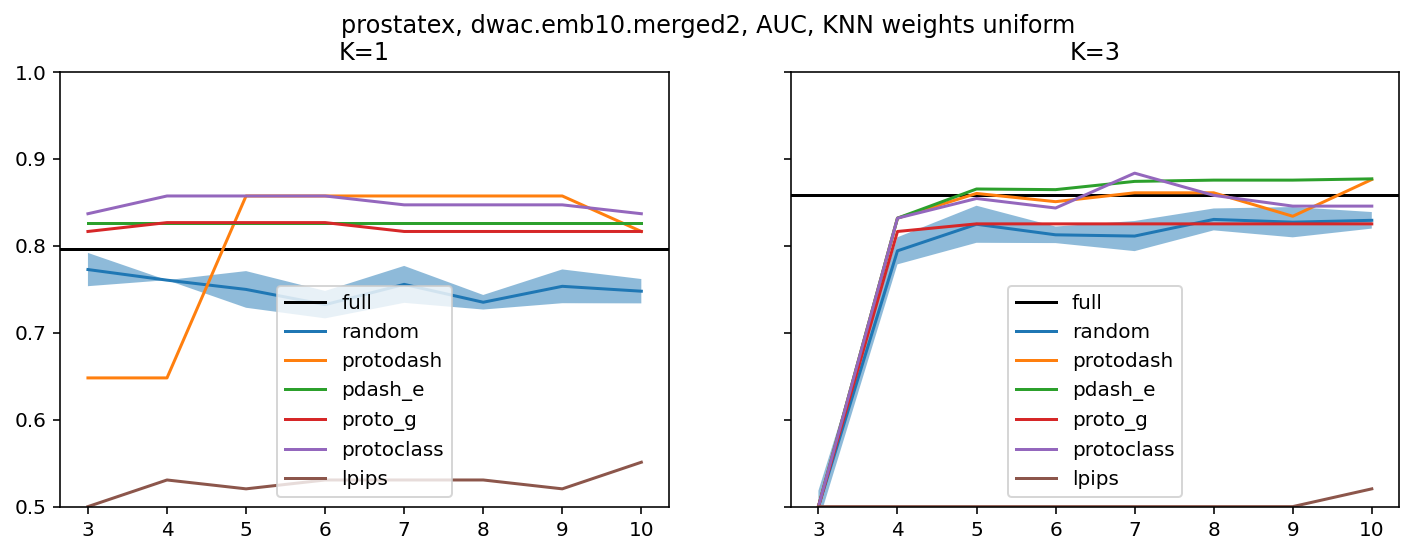

In [202]:
fig, ax = plt.subplots(1, len(k_range), figsize=(12, 4), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(f_scores_knn[k], c='black')
    ax[k].plot(m_range, r_means_knn[k])
    ax[k].fill_between(m_range, r_means_knn[k] + r_confs_knn[k] / 2, r_means_knn[k] - r_confs_knn[k] / 2, alpha=0.5)
    ax[k].plot(m_range, p_scores_knn[k])
    ax[k].plot(m_range, e_scores_knn[k])
    ax[k].plot(m_range, g_scores_knn[k])
    ax[k].plot(m_range, c_scores_knn[k])
    ax[k].plot(m_range, l_scores_knn[k])
    ax[k].set_ylim(0.5, 1)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['full', 'random', 'protodash', 'pdash_e', 'proto_g', 'protoclass', 'lpips'])
fig.suptitle('{}, {}.{}, AUC, KNN weights '.format(dataset, model, name) + WEIGHTS)

Text(0.5, 0.98, 'prostatex, dwac.emb10.merged2, AUC, svm, kernel:linear')

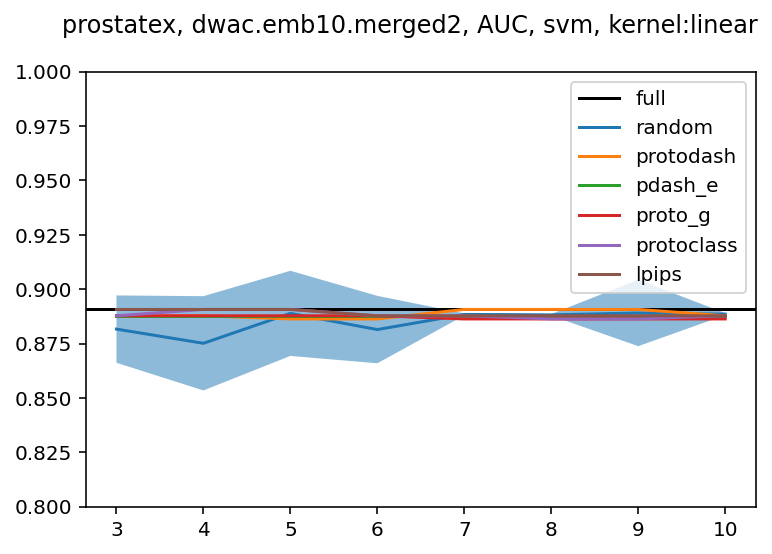

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True)
ax.axhline(f_score_svm, c='black')
ax.plot(m_range, r_means_svm[0])
ax.fill_between(m_range, r_means_svm[0] + r_confs_svm[0] / 2, r_means_svm[0] - r_confs_svm[0] / 2, alpha=0.5)
ax.plot(m_range, p_scores_svm[0])
ax.plot(m_range, e_scores_svm[0])
ax.plot(m_range, g_scores_svm[0])
ax.plot(m_range, c_scores_svm[0])
ax.plot(m_range, l_scores_svm)
ax.set_ylim(0.8, 1)
ax.set_xticks(m_range)
ax.legend(['full', 'random', 'protodash', 'pdash_e', 'proto_g', 'protoclass', 'lpips'])
fig.suptitle('{}, {}.{}, AUC, svm, kernel:{}'.format(dataset, model, name, "linear" if LINEAR else "rbf"))

Text(0.5, 1.0, 'protoclass, dwac.emb10.merged2.t1')

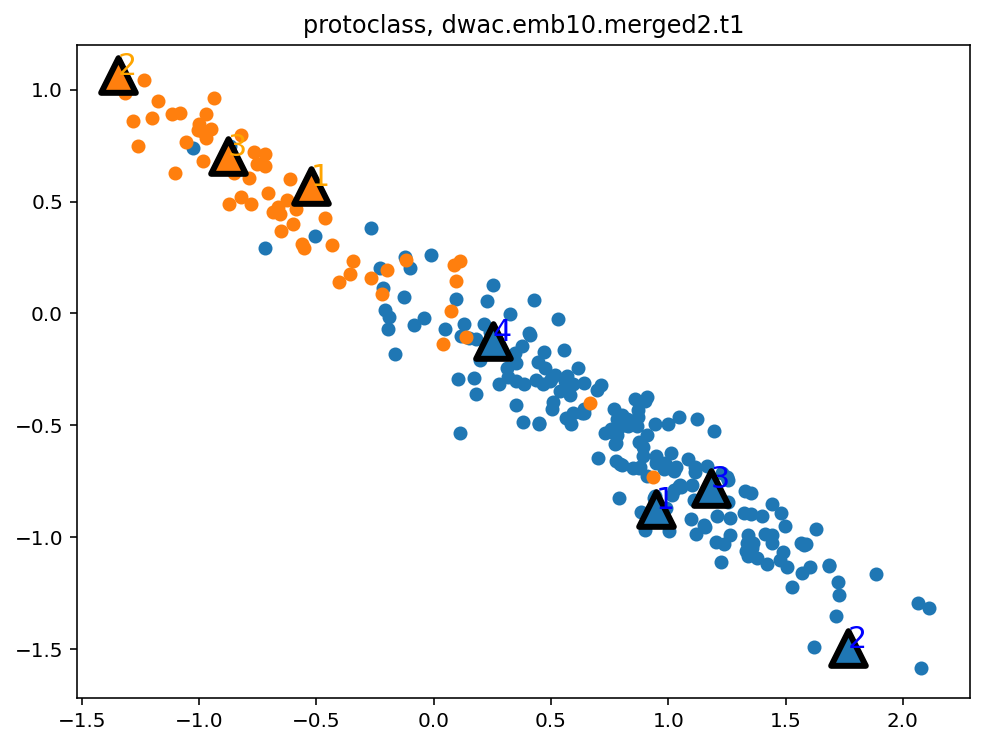

In [11]:
algo = 'protoclass'
index = c_idss[7]
p_index = [i for i in index if i in pos_id]
n_index = [i for i in index if i in neg_id]
vis = data[0]
labels = data[1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
neg_id = np.where(labels==0)[0]
pos_id = np.where(labels==1)[0]
a_id, b_id = neg_id, pos_id
a_proto, b_proto = vis[n_index], vis[p_index]
ax.scatter(vis[a_id][:,0], vis[a_id][:,1])
ax.scatter(vis[b_id][:,0], vis[b_id][:,1])
ax.scatter(a_proto[:,0], a_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
ax.scatter(b_proto[:,0], b_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
# for i, idx in enumerate(index):
#     ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='green', fontsize=15) #, weight='bold'
for i, idx in enumerate(n_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='blue', fontsize=15) #, weight='bold'
for i, idx in enumerate(p_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='orange', fontsize=15) #, weight='bold'
ax.set_title(algo + ', ' + model + '.' + name)

Text(0.5, 1.0, 'protoclass, dwac.emb10.merged2')

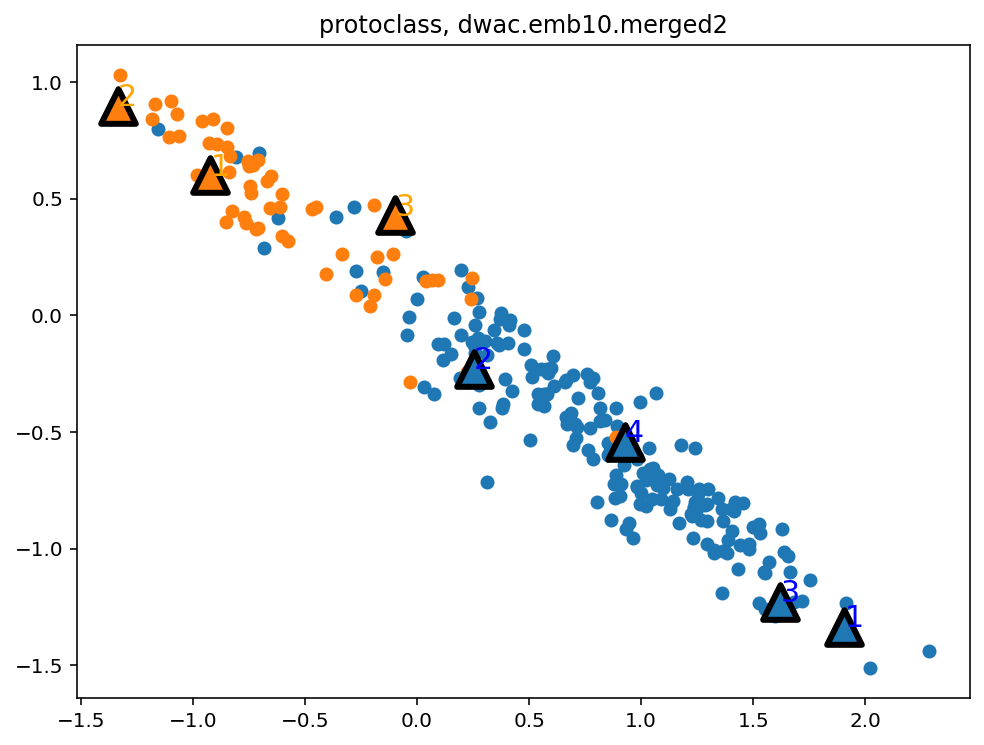

In [ ]:
algo = 'protoclass'
index = c_idss[7]
p_index = [i for i in index if i in pos_id]
n_index = [i for i in index if i in neg_id]
vis = data[0]
labels = data[1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
neg_id = np.where(labels==0)[0]
pos_id = np.where(labels==1)[0]
a_id, b_id = neg_id, pos_id
a_proto, b_proto = vis[n_index], vis[p_index]
ax.scatter(vis[a_id][:,0], vis[a_id][:,1])
ax.scatter(vis[b_id][:,0], vis[b_id][:,1])
ax.scatter(a_proto[:,0], a_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
ax.scatter(b_proto[:,0], b_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
# for i, idx in enumerate(index):
#     ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='green', fontsize=15) #, weight='bold'
for i, idx in enumerate(n_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='blue', fontsize=15) #, weight='bold'
for i, idx in enumerate(p_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='orange', fontsize=15) #, weight='bold'
ax.set_title(algo + ', ' + model + '.' + name)

In [12]:
dist = euclidean_distances(X_train)
p_nn = get_nn(p_index, X_train, m=1)
n_nn = get_nn(n_index, X_train, m=1)
p_nn.ravel(), n_nn.ravel()

(array([239, 229, 103]), array([ 90, 135, 133, 183]))

In [13]:
f_train[n_nn.ravel()]

array(['0103-2', '0144-3', '0142-2', '0182-1'], dtype='<U6')

Text(0.5, 1.0, 'pdash_e, dwac.emb10.merged2, L=1, K=Gaussian')

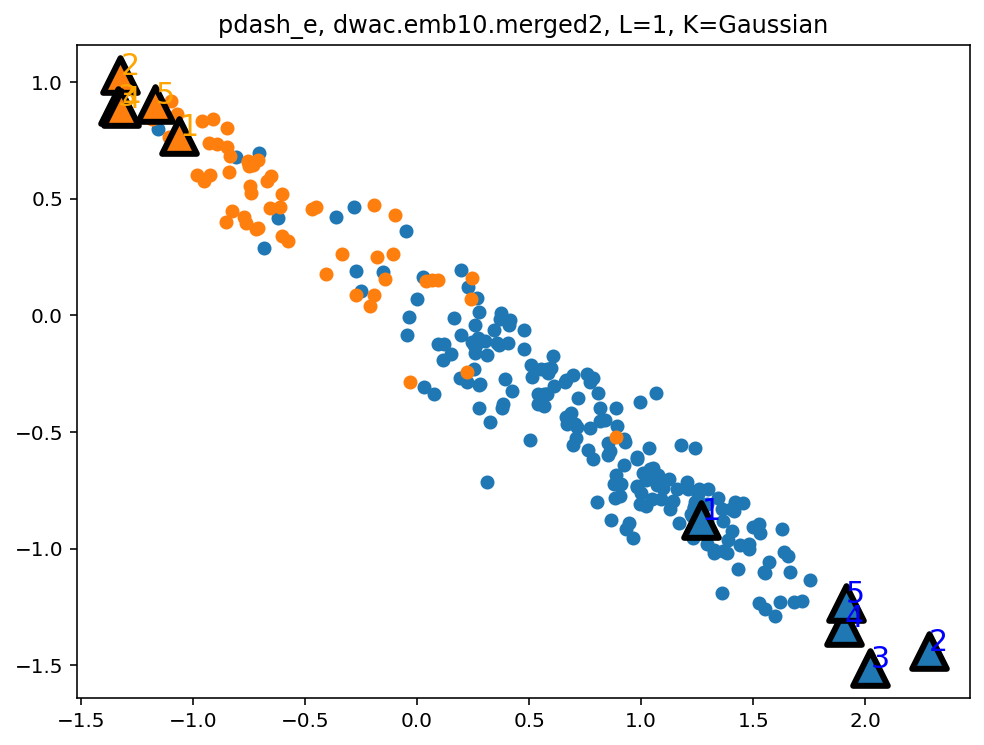

In [ ]:
algo = 'pdash_e'
p_index = e_idss[10][:5]
n_index = e_idss[10][5:]
vis = data[0]
labels = data[1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
neg_id = np.where(labels==0)[0]
pos_id = np.where(labels==1)[0]
a_id, b_id = neg_id, pos_id
a_proto, b_proto = vis[n_index], vis[p_index]
ax.scatter(vis[a_id][:,0], vis[a_id][:,1])
ax.scatter(vis[b_id][:,0], vis[b_id][:,1])
ax.scatter(a_proto[:,0], a_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
ax.scatter(b_proto[:,0], b_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
# for i, idx in enumerate(index):
#     ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='green', fontsize=15) #, weight='bold'
for i, idx in enumerate(n_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='blue', fontsize=15) #, weight='bold'
for i, idx in enumerate(p_index):
    ax.annotate(i+1, (vis[idx,0],vis[idx,1]), c='orange', fontsize=15) #, weight='bold'
ax.set_title(algo + ', ' + model + '.' + name + ", L={}, K={}".format(L, Kernel))

AttributeError: 'numpy.ndarray' object has no attribute 'axhline'

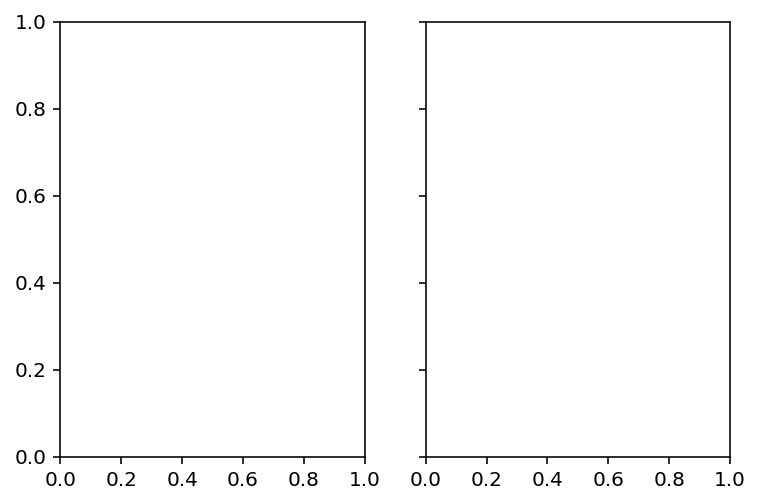

In [17]:
fig, ax = plt.subplots(1, len(k_range), figsize=(6, 4), sharey=True)
for k in range(len(k_range)):
    # ax[k].axhline(f_scores[k], c='black')
    # ax[k].plot(m_range, r_means[k])
    # ax[k].fill_between(m_range, r_means[k] + r_confs[k] / 2, r_means[k] - r_confs[k] / 2, alpha=0.5)
    # ax[k].plot(m_range, p_scores[k])
    # # ax[k].plot(m_range, s_scores[k])
    # # ax[k].set_ylim(0.9, 1.05)
    # ax[k].set_ylim(0.8, 1)
    # ax[k].legend(['full', 'random', 'protodash'], loc='lower right')
    # ax[k].set_title('K={}'.format(k_range[k]))
    ax.axhline(f_scores[k], c='black')
    ax.plot(m_range, r_means[k])
    ax.fill_between(m_range, r_means[k] + r_confs[k] / 2, r_means[k] - r_confs[k] / 2, alpha=0.5)
    ax.plot(m_range, p_scores[k])
    ax.plot(m_range, e_scores[k])
    ax.plot(m_range, g_scores[k])
    # ax.plot(m_range, s_scores[k])
    # ax.set_ylim(0.9, 1.05)
    ax.set_ylim(0, 1)
    ax.legend(['full', 'random', 'pdash', 'pdash_e', 'proto_g'])
    ax.set_title('K={}'.format(k_range[k]))
fig.suptitle('{}.{}, D={}, AUC, KNN weights '.format(model, name, D) + WEIGHTS)